In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn2
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/K05_Kupffer_DT_Ablation_CDAAHFD/'
dataDirectory = '/data/mm10/Kupffer/RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# make folder for figures
if not os.path.isdir('./figures/'):
    os.mkdir('./figures')
    
# make folder for gene lists
if not os.path.isdir('./gene_lists/'):
    os.mkdir('./gene_lists')
    
if not os.path.isdir('./promoter_motif_finding'):
    os.mkdir('./promoter_motif_finding')

# Check qc stats

# Run Oyoung's pipeline to process RNA-seq data consistantly.

In [14]:
ids =  ['DTRneg_Tim4Neg_CDAHFD4w',
        'DTRneg_Tim4Pos_CDAHFD4w',
        'DTRpos_Tim4Neg_CDAHFD4w',
        'DTRpos_Tim4Pos_CDAHFD4w']

In [15]:
dtrn_tim4n = [dataDirectory+'mouse_Clec4fDTRN_M_KupfferTim4Neg_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1870_TDT_l20190926_GTGAAA',
              dataDirectory+'mouse_Clec4fDTRN_M_KupfferTim4Neg_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1926_TDT_l20190926_GTGGCC']

dtrn_tim4p = [dataDirectory+'mouse_Clec4fDTRN_M_KupfferTim4Pos_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1870_TDT_l20190926_AGTTCC',
              dataDirectory+'mouse_Clec4fDTRN_M_KupfferTim4Pos_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1926_TDT_l20190926_ATGTCA']

dtrp_tim4n = [dataDirectory+'mouse_Clec4fDTRP_M_KupfferTim4Neg_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1880_TDT_l20190926_CCGTCC',
              dataDirectory+'mouse_Clec4fDTRP_M_KupfferTim4Neg_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1916_TDT_l20190926_GTCCGC']

dtrp_tim4p = [dataDirectory+'mouse_Clec4fDTRP_M_KupfferTim4Pos_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1880_TDT_l20190926_GGCTAC',
              dataDirectory+'mouse_Clec4fDTRP_M_KupfferTim4Pos_RNA_polyA_DT4wCDAHFD4w_TDTMS_rep1916_TDT_l20190926_AGTCAA']

In [16]:
dtrn_tim4n_ids = [i.split('/')[-1].split('_')[8] for i in dtrn_tim4n]
dtrn_tim4p_ids = [i.split('/')[-1].split('_')[8] for i in dtrn_tim4p]
dtrp_tim4n_ids = [i.split('/')[-1].split('_')[8] for i in dtrp_tim4n]
dtrp_tim4p_ids = [i.split('/')[-1].split('_')[8] for i in dtrp_tim4p]

In [17]:

colors = ['#fdcc8a',
          '#fc8d59',
          '#e34a33',
          '#b30000']

paths = [';'.join(dtrn_tim4n),
         ';'.join(dtrn_tim4p),
         ';'.join(dtrp_tim4n),
         ';'.join(dtrp_tim4p)]

short_ids = [';'.join(dtrn_tim4n_ids),
             ';'.join(dtrn_tim4p_ids),
             ';'.join(dtrp_tim4n_ids),
             ';'.join(dtrp_tim4p_ids)]

In [18]:
pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

# Run O'young RNA pipeline

Run the code below in BASH

    source activate r-ouyangPipe
    
    alignStats.R ./sampleDef.txt > qcStats.txt
    
    mkdir ./expression/
    
    mkdir ./differential/
    
    rnaQuan.R ./sampleDef.txt -o ./expression/

    rnaDiff.R ./sampleDef.txt -c ./expression/rawC.txt \
    -t ./expression/rawT.txt -o ./differential/

    # annotate scatter files with tag counts
    for scatter in ./differential/*scatter.txt;
    do diff2Homer.R -d $scatter -q ./expression/HOMER.rawTPM.txt;
    done

# Collect genes for writing to metascape

We will also save repeat ids for motif finding

In [11]:
log2fc = 1
padj = 0.05
gene_list_dict = {}
id_list_dict = {}

with o'young's pipeline the first member of the comparison is the denominator (negative log2fc is 'up' in first relative to second)

In [12]:
for i in glob.glob('./differential/*homer.txt'):
    print(i)
    groups = [i.split('/')[-1].replace('.scatter.homer.txt', '').split('.vs.')[0],
              i.split('/')[-1].replace('.scatter.homer.txt', '').split('.vs.')[1]]
    print('Group 0: '+groups[0])
    print('Group 1: '+groups[1])
    # read in gene expression data
    df, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        depath=i,
        gepath='./expression/HOMER.rawTPM.txt',
        gene_name_index=True)

    # select differential genes
    df = df.loc[~(df.chr.str.contains('chrX|chrY|ChrUn')), :]
    sig_genes_g0 = df.index[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
    sig_genes_g1 = df.index[(df['padj'] < padj) & (df['log2FoldChange'] >= log2fc)].to_list()
    sig_id_g0 = df.RepeatID[(df['padj'] < padj) & (df['log2FoldChange'] <= -log2fc)].to_list()
    sig_id_g1 = df.RepeatID[(df['padj'] < padj) & (df['log2FoldChange'] >= log2fc)].to_list()
    gene_list_dict[i.split('/')[-1].replace('.scatter.homer.txt', '_up_'+groups[0])] = sig_genes_g0
    gene_list_dict[i.split('/')[-1].replace('.scatter.homer.txt', '_up_'+groups[1])] = sig_genes_g1
    id_list_dict[i.split('/')[-1].replace('.scatter.homer.txt', '_up_'+groups[0])] = sig_genes_g0
    id_list_dict[i.split('/')[-1].replace('.scatter.homer.txt', '_up_'+groups[1])] = sig_genes_g1

./differential/obob_f480high_leptin.vs.obob_f480int_veh.scatter.homer.txt
Group 0: obob_f480high_leptin
Group 1: obob_f480int_veh
ge all transcripts (24940, 20)
Diff Gene selected transcripts (8073, 14)
ge selected transcripts (8073, 20)
./differential/c57bl6j_kupffer.vs.obob_f480high_leptin.scatter.homer.txt
Group 0: c57bl6j_kupffer
Group 1: obob_f480high_leptin
ge all transcripts (24940, 20)
Diff Gene selected transcripts (7738, 14)
ge selected transcripts (7738, 20)
./differential/obob_f480high_veh.vs.obob_f480int_veh.scatter.homer.txt
Group 0: obob_f480high_veh
Group 1: obob_f480int_veh
ge all transcripts (24940, 20)
Diff Gene selected transcripts (8125, 14)
ge selected transcripts (8125, 20)
./differential/obob_f480high_veh.vs.het_f480high_veh.scatter.homer.txt
Group 0: obob_f480high_veh
Group 1: het_f480high_veh
ge all transcripts (24940, 20)
Diff Gene selected transcripts (7914, 14)
ge selected transcripts (7914, 20)
./differential/obob_f480high_leptin.vs.het_f480high_veh.scatte

In [13]:
for key in gene_list_dict.keys():
    print(key)
    print(len(gene_list_dict[key]), 'genes')
    with open('./gene_lists/'+key+'_genes_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in gene_list_dict[key]:
            f.write(i+'\n')
        f.close()

obob_f480high_leptin.vs.obob_f480int_veh_up_obob_f480high_leptin
20 genes
obob_f480high_leptin.vs.obob_f480int_veh_up_obob_f480int_veh
42 genes
c57bl6j_kupffer.vs.obob_f480high_leptin_up_c57bl6j_kupffer
64 genes
c57bl6j_kupffer.vs.obob_f480high_leptin_up_obob_f480high_leptin
66 genes
obob_f480high_veh.vs.obob_f480int_veh_up_obob_f480high_veh
0 genes
obob_f480high_veh.vs.obob_f480int_veh_up_obob_f480int_veh
0 genes
obob_f480high_veh.vs.het_f480high_veh_up_obob_f480high_veh
15 genes
obob_f480high_veh.vs.het_f480high_veh_up_het_f480high_veh
12 genes
obob_f480high_leptin.vs.het_f480high_veh_up_obob_f480high_leptin
46 genes
obob_f480high_leptin.vs.het_f480high_veh_up_het_f480high_veh
105 genes
c57bl6j_kupffer.vs.obob_f480high_veh_up_c57bl6j_kupffer
34 genes
c57bl6j_kupffer.vs.obob_f480high_veh_up_obob_f480high_veh
114 genes
het_f480high_veh.vs.obob_f480int_veh_up_het_f480high_veh
4 genes
het_f480high_veh.vs.obob_f480int_veh_up_obob_f480int_veh
14 genes
obob_f480int_veh.vs.obob_f480high_veh_

In [14]:
for key in id_list_dict.keys():
    print(key)
    print(len(id_list_dict[key]), 'genes')
    with open('./promoter_motif_finding/'+key+'_id_fc_'+str(log2fc)+'_pval_'+str(padj)+'.txt', 'w') as f:
        f.write('Gene\n')
        for i in id_list_dict[key]:
            f.write(i+'\n')
        f.close()

obob_f480high_leptin.vs.obob_f480int_veh_up_obob_f480high_leptin
20 genes
obob_f480high_leptin.vs.obob_f480int_veh_up_obob_f480int_veh
42 genes
c57bl6j_kupffer.vs.obob_f480high_leptin_up_c57bl6j_kupffer
64 genes
c57bl6j_kupffer.vs.obob_f480high_leptin_up_obob_f480high_leptin
66 genes
obob_f480high_veh.vs.obob_f480int_veh_up_obob_f480high_veh
0 genes
obob_f480high_veh.vs.obob_f480int_veh_up_obob_f480int_veh
0 genes
obob_f480high_veh.vs.het_f480high_veh_up_obob_f480high_veh
15 genes
obob_f480high_veh.vs.het_f480high_veh_up_het_f480high_veh
12 genes
obob_f480high_leptin.vs.het_f480high_veh_up_obob_f480high_leptin
46 genes
obob_f480high_leptin.vs.het_f480high_veh_up_het_f480high_veh
105 genes
c57bl6j_kupffer.vs.obob_f480high_veh_up_c57bl6j_kupffer
34 genes
c57bl6j_kupffer.vs.obob_f480high_veh_up_obob_f480high_veh
114 genes
het_f480high_veh.vs.obob_f480int_veh_up_het_f480high_veh
4 genes
het_f480high_veh.vs.obob_f480int_veh_up_obob_f480int_veh
14 genes
obob_f480int_veh.vs.obob_f480high_veh_

# Single gene plots

In [19]:
tpm_mat = pd.read_csv('./expression/rawT.txt', sep='\t', index_col=0)

In [22]:
for i, col in zip(range(0, tpm_mat.shape[1]), tpm_mat.columns):
    print(i,col)

0 DTRneg_Tim4Neg_CDAHFD4w_rep1870
1 DTRneg_Tim4Neg_CDAHFD4w_rep1926
2 DTRneg_Tim4Pos_CDAHFD4w_rep1870
3 DTRneg_Tim4Pos_CDAHFD4w_rep1926
4 DTRpos_Tim4Neg_CDAHFD4w_rep1880
5 DTRpos_Tim4Neg_CDAHFD4w_rep1916
6 DTRpos_Tim4Pos_CDAHFD4w_rep1880
7 DTRpos_Tim4Pos_CDAHFD4w_rep1916


#### Aside - make a tpm plot for chris

In [16]:
# chris_tpm = pd.read_csv('./AJ Balb C57 Healthy NASH CCL4.csv', index_col=0)

# chris_tpm_new = chris_tpm.merge(tpm_mat.iloc[:, 2:],
#                                 left_index=True,
#                                 right_index=True,
#                                 how='left')

# chris_tpm_new.to_csv('./AJ Balb C57 Healthy NASH CCL4 obob leptin.csv')

In [23]:
groups = [[0,1],
          [2,3],
          [4,5],
          [6,7]]

group_labels = ['DTRneg_Tim4neg_CDAHFD4wk',
                'DTRneg_Tim4pos_CDAHFD4wk',
                'DTRpos_Tim4neg_CDAHFD4wk',
                'DTRpos_Tim4pos_CDAHFD4wk']

colors = ['#fdcc8a',
          '#fc8d59',
          '#e34a33',
          '#b30000']


# make legend
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

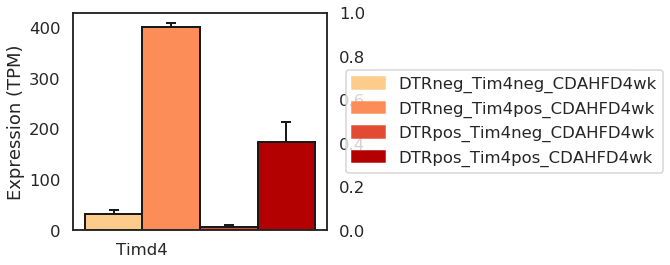

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

gene_list_bar_plot(['Timd4'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width=0.15,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center');
axs[1].spines['top'].set_visible(False);
axs[1].spines['right'].set_visible(False);
axs[1].spines['left'].set_visible(False);
axs[1].spines['bottom'].set_visible(False);
axs[1].set_xticklabels('');

Plot with F480Hi only

In [23]:
groups = [[0,1],
          [2,3],
          [4,5,6],
          [7,8]]

group_labels = ['c57bl6j_kupffer',
                'het_f480high_veh',
                'obob_f480high_veh',
                'obob_f480high_leptin']

colors = ['#bdbdbd',
          '#636363',
          '#fc9272',
          '#de2d26']

# make legend
legend_elements = []
for lab, col in  zip(group_labels, colors):
    legend_elements.append(Patch(label=lab, color=col))

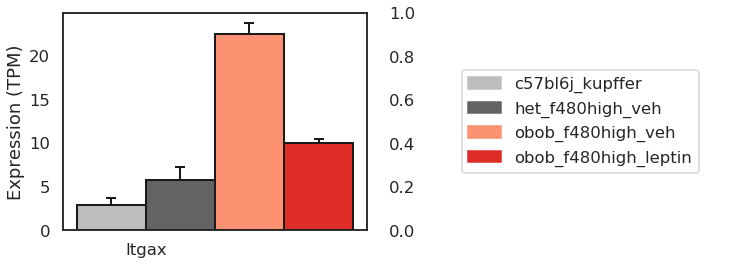

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

gene_list_bar_plot(['Itgax'],
                   tpm_mat,
                   groups=groups,
                   group_labels = group_labels,
                   colors = colors,
                   width = 0.2,
                   ax=axs[0])

axs[0].get_legend().remove()

axs[1].legend(handles=legend_elements, loc='center');
axs[1].spines['top'].set_visible(False);
axs[1].spines['right'].set_visible(False);
axs[1].spines['left'].set_visible(False);
axs[1].spines['bottom'].set_visible(False);
axs[1].set_xticklabels('');